생활인구 증감은 자동차 등록 증감에 어떤 영향을 미치는가?

In [1]:
import pandas as pd
from sqlalchemy import create_engine

db_user = "root"
db_password = "12341234"
db_host = "localhost"
db_port = "3306"
db_name = "miniproject"

engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

df = pd.read_sql("SELECT * FROM seoul_analysis_view", engine)
df.head()


,district_id,district_name,year,population,population_diff,car_count,car_diff,cctv_count
0,1,종로구,2021,156567,-5417,50049,-11,149
1,1,종로구,2022,153684,-2883,50832,783,149
2,1,종로구,2023,152212,-1472,51000,168,149
3,1,종로구,2024,150550,-1662,50482,-518,149
4,1,종로구,2025,149478,-1072,50083,-399,149


In [14]:
df[["population_diff", "car_diff"]].describe()


,population_diff,car_diff
count,125.0000,125.000000
mean,-3287.6400,383.552000
std,5724.8184,2307.745983
min,-13768.0000,-3984.000000
25%,-6552.0000,-797.000000
50%,-3473.0000,-113.000000
75%,-1580.0000,1107.000000
max,34453.0000,12951.000000


In [15]:
df[["population_diff", "car_diff"]].corr()


,population_diff,car_diff
population_diff,1.000000,0.509377
car_diff,0.509377,1.000000


In [2]:
X = df[["population_diff", "population", "cctv_count", "year"]]
y = df["car_diff"]


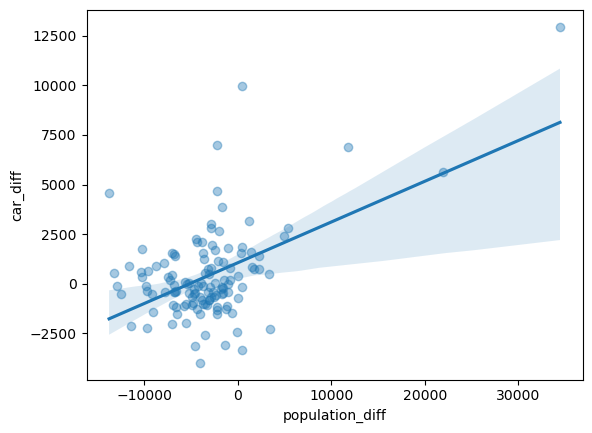

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(
    x="population_diff",
    y="car_diff",
    data=df,
    scatter_kws={"alpha": 0.4}
)
plt.show()

In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

coef = pd.Series(lr.coef_, index=X.columns)
coef.sort_values(ascending=False)


population_diff      0.288578
population           0.002905
cctv_count          -0.247623
year              -904.044835
dtype: float64

In [18]:
from sklearn.linear_model import LinearRegression

X = df[["population_diff"]]
y = df["car_diff"]

model = LinearRegression()
model.fit(X, y)

coef = model.coef_[0]
intercept = model.intercept_


다중선형회귀 분석 결과, 생활인구 증감은 자동차 등록 증감에 가장 큰 양의 영향을 미치는 변수로 나타났다. 반면 CCTV 설치 수는 자동차 등록 증감에 대한 설명력이 제한적인 것으로 확인되었다.

In [8]:
# 표준화 계수 비교

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pandas as pd

X = df[["population_diff", "population", "cctv_count", "year"]]
y = df["car_diff"]

X_scaled = StandardScaler().fit_transform(X)

lr_std = LinearRegression()
lr_std.fit(X_scaled, y)

std_coef = pd.Series(lr_std.coef_, index=X.columns)
std_coef.sort_values(ascending=False)


population_diff    1645.432944
population          359.465426
cctv_count          -63.575023
year              -1278.512467
dtype: float64

회귀 계수는 변수 단위에 따라 크기가 달라지므로
표준화 회귀 계수를 기준으로 영향력을 비교하였다.

In [4]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

ridge.fit(X, y)

ridge_coef = pd.Series(
    ridge.named_steps["ridge"].coef_,
    index=X.columns
)

ridge_coef.sort_values(ascending=False)


population_diff    1625.988282
population          356.598205
cctv_count          -61.394166
year              -1261.373886
dtype: float64

In [5]:
from sklearn.metrics import r2_score, mean_absolute_error

pred_lr = lr.predict(X)
pred_ridge = ridge.predict(X)

print("LR R2:", r2_score(y, pred_lr))
print("Ridge R2:", r2_score(y, pred_ridge))


LR R2: 0.5545512108018229
Ridge R2: 0.5544688478951671


회귀 분석 결과, 생활인구 증감은 자동차 등록 증감에 유의미한 양의 영향을 미치는 핵심 변수로 확인되었다. Ridge 회귀를 적용한 결과에서도 동일한 방향성이 유지되어 분석 결과의 안정성을 확보하였다.

기본 회귀 분석 이후, 변수 단위 차이에 따른 해석의 한계를 보완하기 위해 표준화된 데이터를 사용한 회귀 분석을 추가로 진행하였다.

In [11]:
# 단위 차이 제거 -> 변수 간 영향력 크기 비교

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pandas as pd

X = df[["population_diff", "population", "cctv_count", "year"]]
y = df["car_diff"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr_std = LinearRegression()
lr_std.fit(X_scaled, y)

std_coef = pd.Series(
    lr_std.coef_,
    index=X.columns
).sort_values(ascending=False)

std_coef


population_diff    1645.432944
population          359.465426
cctv_count          -63.575023
year              -1278.512467
dtype: float64

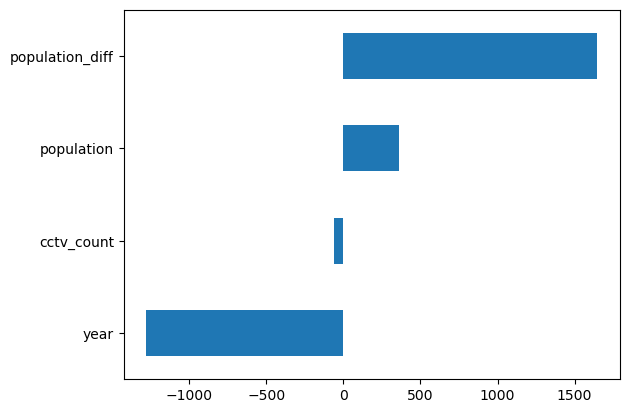

In [13]:
std_coef.sort_values().plot(kind="barh")
plt.show()


표준화 회귀 분석 결과, 생활인구 증감은 자동차 등록 증감에 가장 큰 영향을 미치는 변수로 확인되었다. 연도 변수는 음의 영향을 보여 차량 증가 속도가 점차 둔화되고 있음을 시사한다. 반면 CCTV 설치 수는 상대적으로 영향력이 낮아 차량 증가의 직접적 요인으로 보기에는 한계가 있었다.

왜 그냥 계수 말 안했나?
회귀 계수는 변수 단위에 따라 크기가 달라지므로,
변수 간 상대적 영향력을 비교하기 위해
표준화 회귀 계수를 기준으로 해석하였다.